In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

from sklearn import metrics
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Input, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping


import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

import sys
sys.path.append(parent_dir)

import BalanceDataset as balance
import MachineLearningModels as ml_models
import DeepLearningModels as dl_models

import shap

## Dataset Description

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- amount - amount of the transaction in local currency.
- nameOrig - customer who started the transaction
- oldbalanceOrg - initial balance before the transaction
- newbalanceOrig - new balance after the transaction
- nameDest - customer who is the recipient of the transaction
- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [2]:
data = pd.read_csv('paysim.csv')
df = data.copy()

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
 df.duplicated().sum()

0

In [8]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [9]:
#df = df.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns') #gereksiz sütunları çıkardık

In [10]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [11]:
#fig = px.box(df, y="amount")
#fig.show()

## EDA

In [12]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [13]:
# İşlemlerin yapıldığı kaynağın kontrol edilmesi.
transfer_df = df[((df['type']=='TRANSFER') & df['isFraud']==1)] 
transfer_df['nameOrig'].value_counts()

C1305486145    1
C202278158     1
C12585107      1
C946427395     1
C1069177491    1
              ..
C2090764492    1
C1794935564    1
C318078280     1
C939293281     1
C1685995037    1
Name: nameOrig, Length: 4097, dtype: int64

In [14]:
# İşlemlerin nakde çevrildiği varış noktasının kontrol edilmesi.
cash_out_fraud = df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 1)]
cash_out_fraud['nameDest'].value_counts()

C200064275     2
C1399829166    2
C1650668671    2
C2129197098    2
C1013511446    2
              ..
C1566713324    1
C1955464150    1
C1104137869    1
C377165949     1
C873221189     1
Name: nameDest, Length: 4091, dtype: int64

In [15]:
fraud_trans = df[df['isFraud'] == 1]
valid_trans = df[df['isFraud'] == 0]

trans_transfer = df[df['type'] == 'TRANSER']
trans_cashout = df[df['type'] == 'CASH_OUT']

print('Nakit çekmek için kullanılan alıcı hesabı var mı?')
trans_transfer.nameDest.isin(trans_cashout.nameOrig).any()

Nakit çekmek için kullanılan alıcı hesabı var mı?


False

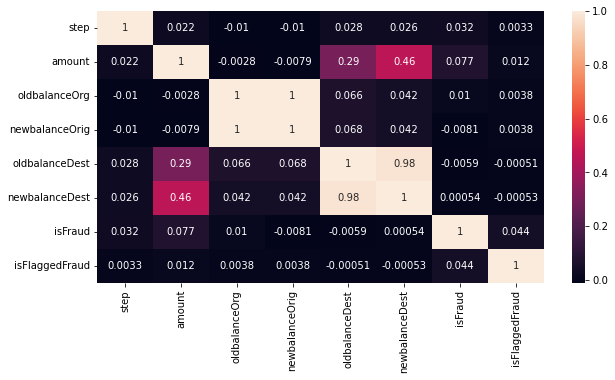

In [16]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),annot=True);

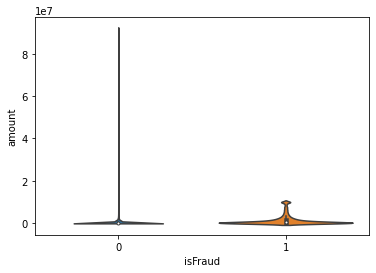

In [17]:
sns.violinplot(x = df['isFraud'],y = df['amount']);

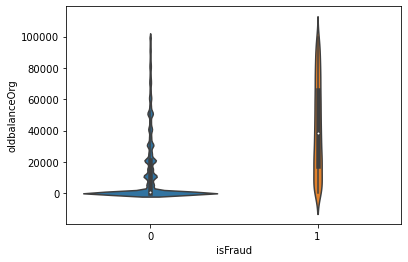

In [18]:
sns.violinplot(x = df['isFraud'],y = df[df['oldbalanceOrg']<100000].oldbalanceOrg);

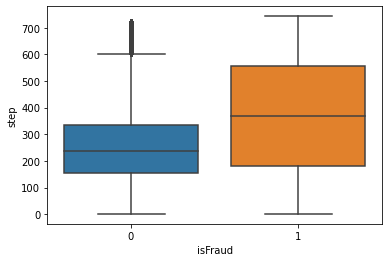

In [19]:
sns.boxplot(x=df.isFraud,y=df.step);

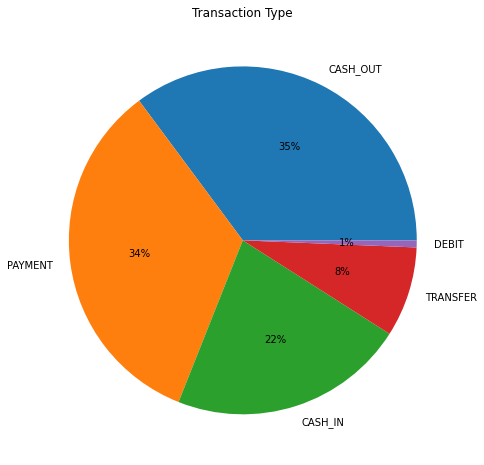

In [20]:
plt.figure(figsize=(10,8))
plt.pie(df.type.value_counts().values,labels=df.type.value_counts().index,  autopct='%.0f%%')
plt.title("Transaction Type")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = {}
for i in df.select_dtypes('object').columns:
    encoder[i] = LabelEncoder()
    df[i] = encoder[i].fit_transform(df[i])

df=pd.concat([df,pd.get_dummies(df['type'], prefix='type_')],axis=1)
df.drop(['type'],axis=1,inplace = True)

df.head()

## Sonuçlar

* Dolandırıcılık işlemlerimiz TRANSFER ve CASH_OUT işlem tipinde yapılmaktadır.

* TRANSFER'deki dolandırıcılık işlemleri 4097 ve CASH_OUT 4116 adet.

* Dolandırıcılık işlemleri genellikle Müşteriden Müşteriye yapılmakta.

* Alım ve Gönderim için kullanılan işlem hesabı, Dolandırıcılık işlemlerinde Aynı değil.

## Preprocessing

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns.size

In [ ]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(25,16))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numeric_columns, rows=int(numeric_columns.size/3)+1, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

## Feature Engineering (chi2, ANNOVA)

### ...

## Model Oluşturma

In [ ]:
#df.drop(columns=['type','nameOrig','nameDest'], inplace=True)
df.drop(columns=['nameOrig','nameDest'], inplace=True)

In [ ]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [ ]:
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_chi2, y, test_size = 0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42, stratify=y)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train_ros, y_train_ros = balance.balancedWithRandomOverSampler(X_train,y_train)

In [ ]:
X_train_rus, y_train_rus = balance.balancedWithRandomUnderSampler(X_train,y_train)

In [ ]:
X_train_smote, y_train_smote = balance.balanceWithSMOTE(X_train, y_train)

In [ ]:
X_train_adasyn, y_train_adasyn = balance.balanceWithADASYN(X_train, y_train)

In [ ]:
ml_models_list = [ 
                  lgb.LGBMClassifier(), 
                  XGBClassifier(), 
                  AdaBoostClassifier(),
                  GradientBoostingClassifier(),
                  CatBoostClassifier()
                 ]

In [ ]:
for i in ml_models_list:
    ml_models.model_performance(i, X_train, X_test, y_train, y_test, "baseline")

In [ ]:
ml_models.all_performances.sort_values(by=['f1_score','AUC'], ascending=False)

In [ ]:
for i in ml_models_list:
    ml_models.model_performance(i, X_train_ros, X_test, y_train_ros, y_test, "RandomOverSampler")
    ml_models.model_performance(i, X_train_rus, X_test, y_train_rus, y_test, "RandomUnderSampler")
    ml_models.model_performance(i, X_train_smote, X_test, y_train_smote, y_test, "SMOTE")
    ml_models.model_performance(i, X_train_adasyn, X_test, y_train_adasyn, y_test, "ADASYN")

In [ ]:
ml_model_performances = ml_models.all_performances.sort_values(by=['f1_score','AUC'], ascending=False)
ml_model_performances

In [ ]:
ml_models.display_all_confusion_matrices(y_test)

# DEEP LEARNING

## Preprocessing

In [ ]:
dl_model_performances= pd.DataFrame(columns=["model_name","precision","recall","f1_score","AUC"])

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
parameters={
    'X_train_scaled' : X_train_scaled,
    'X_test_scaled' : X_test_scaled,
    'y_train' : y_train,
    'y_test' : y_test
}

In [ ]:
dl_models_list= [
            dl_models.ANN_model(**parameters),
            dl_models.CNN_model(**parameters),
            dl_models.RNN_model(**parameters),
            dl_models.LSTM_model(**parameters),
            dl_models.autoencoder(**parameters)
    
]

In [ ]:
for i in range(len(dl_models)):
    dl_model_performances.loc[len(dl_model_performances.index)] = dl_models[i]

In [ ]:
dl_model_performances.sort_values(by=['f1_score','AUC'], 
                                  ascending=False).reset_index(drop=True)

In [ ]:
final_result = pd.concat([ml_model_performances, dl_model_performances])

In [ ]:
final_result.sort_values(by=['f1_score','AUC'], 
                                  ascending=False).reset_index(drop=True)

In [ ]:
ml_models.all_performances.sort_values(by=['f1_score','AUC'], 
                                  ascending=False).reset_index(drop=True)[:5]

In [ ]:
dl_model_performances

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

# Create the Autoencoder model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(X_train.shape[1], activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
model.fit(X_train, X_train, epochs=10, batch_size=64, validation_data=(X_test, X_test))

# Use the trained Autoencoder for anomaly detection
reconstructed_data = model.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed_data, 2), axis=1)
threshold = np.mean(mse) + np.std(mse)  # Define a threshold for anomaly detection

# Classify instances as fraudulent or non-fraudulent based on the threshold
y_pred = [1 if error > threshold else 0 for error in mse]

# Evaluate the model
accuracy = np.mean(np.equal(y_test, y_pred))
print("Accuracy:", accuracy)


In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [ ]:
#sklearn.metrics.get_scorer_names()

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [400,500,600],
    'max_depth': [5, 6, 7, 8],
    'random_state': [12, 13, 14]
}

for i in ml_models_list:
    grid_rf = GridSearchCV(i, param_grid=params,
                       cv=kf, scoring='f1').fit(X_train, y_train)
    print(i, ' Best parameters:', grid_rf.best_params_)
    print(i, ' Best score:', grid_rf.best_score_)

In [ ]:
y_pred = grid_rf.predict(X_test)

params = {
    'n_estimators': 100,
    'n_jobs': 3
}

ml_models = [ lgb.LGBMClassifier(**params)] 
             #, XGBClassifier(**params)
             #, AdaBoostClassifier()
             #,GradientBoostingClassifier(),CatBoostClassifier()]

In [ ]:
params = {
    'max_depth': 6, 
    'n_estimators': 200, 
    'random_state': 13
}

ml_models = [ lgb.LGBMClassifier(**params)] 
             #, XGBClassifier(**params)
             #, AdaBoostClassifier()
             #,GradientBoostingClassifier(),CatBoostClassifier()]

In [ ]:
for i in ml_models:
    mtap.model_performance(i, X_train, X_test, y_train, y_test, "baseline_ht")

In [ ]:
mtap.all_performances.sort_values(by=['f1_score'], ascending=False)